In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 10)
!date

%load_ext autoreload
%autoreload 2

Wed Jul 17 15:31:03 PDT 2019


# Consistent models in DisMod-MR from Vivarium artifact draw

Take i, r, f, p from a Vivarium artifact, and make a consistent version of them.  See how it compares to the original.

In [2]:
np.random.seed(123456)

In [3]:
# if dismod_mr is not installed, it should possible to use
# pip install dismod_mr

In [4]:
import dismod_mr

In [5]:
import vivarium_public_health

# Consistent fit with all data

Let's start with a consistent fit of the simulated PD data.  This includes data on prevalence, incidence, and SMR, and the assumption that remission rate is zero.  All together this counts as four different data types in the DisMod-II accounting.

In [6]:
from vivarium_public_health.dataset_manager import Artifact
art = Artifact('/share/costeffectiveness/artifacts/obesity/obesity.hdf')

In [7]:
art.keys

[EntityKey(metadata.keyspace),
 EntityKey(metadata.versions),
 EntityKey(metadata.locations),
 EntityKey(population.demographic_dimensions),
 EntityKey(population.structure),
 EntityKey(cause.all_causes.cause_specific_mortality),
 EntityKey(population.theoretical_minimum_risk_life_expectancy),
 EntityKey(cause.ischemic_heart_disease.restrictions),
 EntityKey(cause.ischemic_stroke.restrictions),
 EntityKey(cause.diabetes_mellitus_type_2.restrictions),
 EntityKey(cause.asthma.restrictions),
 EntityKey(cause.gout.restrictions),
 EntityKey(cause.osteoarthritis.restrictions),
 EntityKey(cause.chronic_kidney_disease_due_to_hypertension.restrictions),
 EntityKey(cause.chronic_kidney_disease_due_to_glomerulonephritis.restrictions),
 EntityKey(cause.chronic_kidney_disease_due_to_other_and_unspecified_causes.restrictions),
 EntityKey(cause.chronic_kidney_disease_due_to_diabetes_mellitus_type_2.restrictions),
 EntityKey(risk_factor.high_body_mass_index_in_adults.exposure),
 EntityKey(risk_factor.

In [8]:
def format_for_dismod(df, data_type):
    df = df.query('draw==0 and sex=="Female" and year_start==2017').copy()
    df['data_type'] = data_type
    df['area'] = 'all'
    df['standard_error'] = 0.001
    df['upper_ci'] = np.nan
    df['lower_ci'] = np.nan
    df['effective_sample_size'] = 10_000

    df['sex'] = 'total'
    df = df.rename({'age_group_start': 'age_start',
                                     'age_group_end': 'age_end',}, axis=1)
    return df

p = format_for_dismod(art.load('cause.ischemic_heart_disease.prevalence'), 'p')

In [9]:
i = format_for_dismod(art.load('cause.ischemic_heart_disease.incidence'), 'i')

In [10]:
f = format_for_dismod(art.load('cause.ischemic_heart_disease.excess_mortality'), 'f')

In [11]:
m_all = format_for_dismod(art.load('cause.all_causes.cause_specific_mortality'), 'm_all')

In [12]:
csmr = format_for_dismod(art.load('cause.ischemic_heart_disease.cause_specific_mortality'), 'csmr') # could also try 'pf'

In [13]:
p.standard_error *= 10
p

,draw,location,sex,age_start,age_end,year_start,year_end,value,data_type,area,standard_error,upper_ci,lower_ci,effective_sample_size
27,0,United States,total,0.000000,0.019178,2017,2018,0.000000,p,all,0.01,NaN,NaN,10000
55,0,United States,total,0.019178,0.076712,2017,2018,0.000000,p,all,0.01,NaN,NaN,10000
83,0,United States,total,0.076712,1.000000,2017,2018,0.000000,p,all,0.01,NaN,NaN,10000
111,0,United States,total,1.000000,5.000000,2017,2018,0.000000,p,all,0.01,NaN,NaN,10000
139,0,United States,total,5.000000,10.000000,2017,2018,0.000000,p,all,0.01,NaN,NaN,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,0,United States,total,75.000000,80.000000,2017,2018,0.105724,p,all,0.01,NaN,NaN,10000
559,0,United States,total,80.000000,85.000000,2017,2018,0.130353,p,all,0.01,NaN,NaN,10000
587,0,United States,total,85.000000,90.000000,2017,2018,0.139944,p,all,0.01,NaN,NaN,10000
615,0,United States,total,90.000000,95.000000,2017,2018,0.114865,p,all,0.01,NaN,NaN,10000


In [14]:
f.standard_error *= 10

In [15]:
i.standard_error *= 10

In [16]:
dm = dismod_mr.data.ModelData()
dm.input_data = pd.concat([p, i, f, m_all,
                          csmr
                          ], ignore_index=True)
for rate_type in 'ifr':
    dm.set_knots(rate_type, [0,40,60,80,90,100])

dm.set_level_value('i', age_before=30, age_after=101, value=0)
dm.set_increasing('i', age_start=50, age_end=100)

dm.set_level_value('p', value=0, age_before=30, age_after=101)

dm.set_level_value('r', value=0, age_before=100, age_after=101)
# d.hierarchy, d.output_template = data_simulation.small_output()


In [17]:
dm.input_data.data_type.value_counts()

m_all    23
csmr     23
p        23
i        23
f        23
Name: data_type, dtype: int64

In [18]:
dm.setup_model(rate_model='normal', include_covariates=False)

/ihme/homes/abie/projects/2019/dismod_mr/src/dismod_mr/model/covariates.py:85: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: (U[col].max() > 0) and (model.hierarchy.node[col].get('level') > model.hierarchy.node[root_area]['level']), axis=1)  # drop columns with only zeros and which are for higher levels in hierarchy
/ihme/homes/abie/projects/2019/dismod_mr/src/dismod_mr/model/covariates.py:99: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: 1 <= U[col].sum() < len(U[col]) or col in keep, axis=1)
/ihme/homes/abie/projects/2019/dismod_mr/src/dismod_mr/model/covariates.py:187: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  X = input_data.select(lambda col: col.startswith('x_'), axis=1)


In [19]:
import pymc as pm
m = pm.MAP(dm.vars)

In [20]:
%%time
m.fit(verbose=1)

Current log-probability : 196.502187
Current log-probability : 202.972983
Current log-probability : 204.554436
Current log-probability : 205.146653
Current log-probability : 205.422638
Current log-probability : -inf
Current log-probability : 205.529642
Current log-probability : 205.540184
Optimization terminated successfully.
         Current function value: -205.540184
         Iterations: 8
         Function evaluations: 10966
CPU times: user 29.3 s, sys: 29.9 ms, total: 29.3 s
Wall time: 29.3 s


In [21]:
from IPython.core.pylabtools import figsize
figsize(11, 5.5)

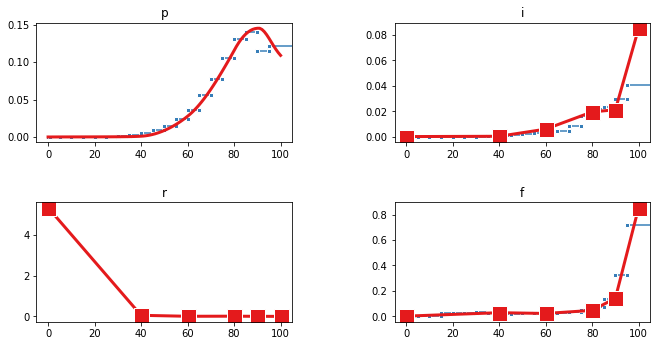

In [22]:
dm.plot()

In [23]:
!date

Wed Jul 17 15:31:53 PDT 2019
